# Machine Learning Project to Predict Presidential Tweets

*by Kevin Truong, April 28, 2024*

## Motivations

For my CS 445 project, I decided to try to incorporate my passion for music with my computer science skills to develop music recommendations using machine learning algorithms. I have always been interested in music, anything from electronic dance music to rock metal, so it made sense to create a project that involved analyzing all kinds of music. 

While I love to listen to music from all types of genres and time periods, I have found that it is not always easy to find new music that fits what I already have been listening to. I usually find a song that I like, so I use Spotify to create a radio based on that song. Spotify then generates a playlist of songs that it thinks you will like, given the input song or playlist. Usually this doesn’t give me great recommendations, so I then search through other user playlists based on that song to find songs that have similar energy manually, which is a tedious and time-consuming process.

So with this dilemma in mind, my goal with this project is to generate music recommendations using machine learning algorithms. By the end of this project I want to at least generate a couple songs based on an input song so I can assess the merit of using machine learning to recommend songs.

## Dataset and Feature Selection

### Datasets
To start my research, I started by looking through datasets and other machine learning projects done on music classification. I found all sorts of data sets with all kinds of musical information and features. Below, I’ve listed a couple of the datasets I looked into.
- Music Genre Classification: A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)

- Million Song Challenge Dataset: The dataset contains the analysis and metadata for a million songs. The goal is to provide a large dataset for researchers to report results on, hence encouraging algorithms that scale to commercial sizes.

- Spotify Tracks Dataset: This is a dataset of Spotify tracks over a range of 125 different genres. Each track has some audio features associated with it.

### Feature Selection
After researching all the datasets and looking into how other people were using musical features to analyze music using machine learning, I found that there were three main approaches to data and feature selection when dealing with music and audio.

- Low-level audio feature selection through the direct analysis of the audio spectrogram of each song. These features provide detailed information about the audio signal itself and are often used for tasks like genre classification, mood detection, and audio similarity analysis, which would be fitting for my project. Low-level audio analysis provides features such as spectral flux, MFCCs (mel-frequency cepstral coefficients), and chroma features that capture nuanced aspects of music, enabling tasks like genre classification and mood detection. While this provides potential for deep feature analysis, extracting low-level features often results in high-dimensional feature vectors, which can lead to increased computational complexity and require larger datasets for training.

- High-level audio feature selection through analysis of more abstract, predefined audio features like acousticness, instrumentalism, and tempo, which describe music in terms that are typically used by or are applicable to humans. While this provides a more abstract representation of music, reducing the dimensionality of the feature space and potentially improving model efficiency, high-level features may not capture fine-grained nuances of music as effectively as low-level features, potentially leading to loss of information.

- User-based features are given by collecting data on users’ playlists, liked songs, and listening histories. These features provide insights into individual user preferences and behaviors. User-based features allow for more personalized recommendations by analyzing user data and providing more accurate insights into users' musical tastes, habits, and contextual preferences. While this is how most popular streaming services generate recommendations, User-based features rely on sufficient user data to make meaningful recommendations, and sparse or incomplete data can limit the effectiveness of the mode.

### Decision

I have already done a music project for another class where I created a social media-type app for music and used Spotify’s web API to pull up user listening histories and display them publicly. When working on this project, there was a part of Spotify’s web API that interested me, which was their endpoints for audio features. Basically, every song in Spotify's music library was associated with a set of audio features. Since Spotify is my primary music streaming service, I saw it fit to incorporate its API into my project.

In [ ]:
# collecting data using spotify web api and python
import spotipy
import pandas as pd
import csv
import time
from spotipy.oauth2 import SpotifyClientCredentials

cid = "6386e80418a140a3887a2f3d0113e6b4"
secret = "72675cbf20f146c588473679d09bd5aa"
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlist_link = "https://open.spotify.com/playlist/7vFXGdbE9ILN8hMz2hKdNt?si=03ff4a851b6c4314"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]

with open('spotify_playlist_data.csv', 'w', newline='') as file:
    csv_writer = csv.writer(file)
    offset = 0
    limit = 100
    while True:
        try:
            playlist_tracks = sp.playlist_tracks(playlist_URI, offset=offset, limit=limit)["items"]
            if not playlist_tracks:
                break
            track_uris = [track["track"]["uri"] for track in playlist_tracks]
            audio_features_batch = sp.audio_features(track_uris)
            for track, features in zip(playlist_tracks, audio_features_batch):
                track_uri = track["track"]["uri"]
                track_name = track["track"]["name"]
                artist_name = track["track"]["artists"][0]["name"]
                album = track["track"]["album"]["name"]
                track_pop = track["track"]["popularity"]

                # Ensure the audio features are available
                if features is not None:
                    # Write the data directly to the CSV file
                    csv_writer.writerow([track_name,artist_name,track_pop,features['danceability'],features['energy'],features['key'],features['loudness'],features['mode'],features['speechiness'],features['acousticness'],features['instrumentalness'],features['liveness'],features['valence'],features['tempo']])
            time.sleep(5)
            offset += limit
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', 0))
                print(f"Rate limited. Retrying after {retry_after} seconds...")
                time.sleep(retry_after)
            else:
                raise
offset = 0

In [35]:
# load the dataset into dataframe
import pandas as pd
from sklearn.preprocessing import StandardScaler

music_data = pd.read_csv('spotify_data.csv')

print(music_data.head())  # Print the first few rows of the dataframe
print(music_data.describe())   # Print summary statistics for each column
print(music_data.info())   # Print information about the dataframe, including the number of rows and columns, and the data types of each column

     track_name        artist_name  popularity  danceability  energy  key  \
0          ////              Covey          38         0.564   0.605   11   
1           \\\            c678924          53         0.676   0.449    1   
2           $10       Good Morning          66         0.624   0.596    4   
3         $TING  The Neighbourhood          60         0.566   0.777    9   
4  10x Stronger       Dominic Fike          67         0.420   0.391    4   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0   -10.445     1       0.0299       0.64000           0.00633    0.1960   
1   -12.224     0       0.0764       0.00124           0.91700    0.1630   
2    -9.804     1       0.0314       0.47500           0.20300    0.1190   
3    -6.190     0       0.0505       0.62200           0.75800    0.0985   
4    -6.450     0       0.0291       0.95500           0.64100    0.4260   

   valence    tempo  
0    0.607  118.950  
1    0.511  159.976  
2    0.896  12

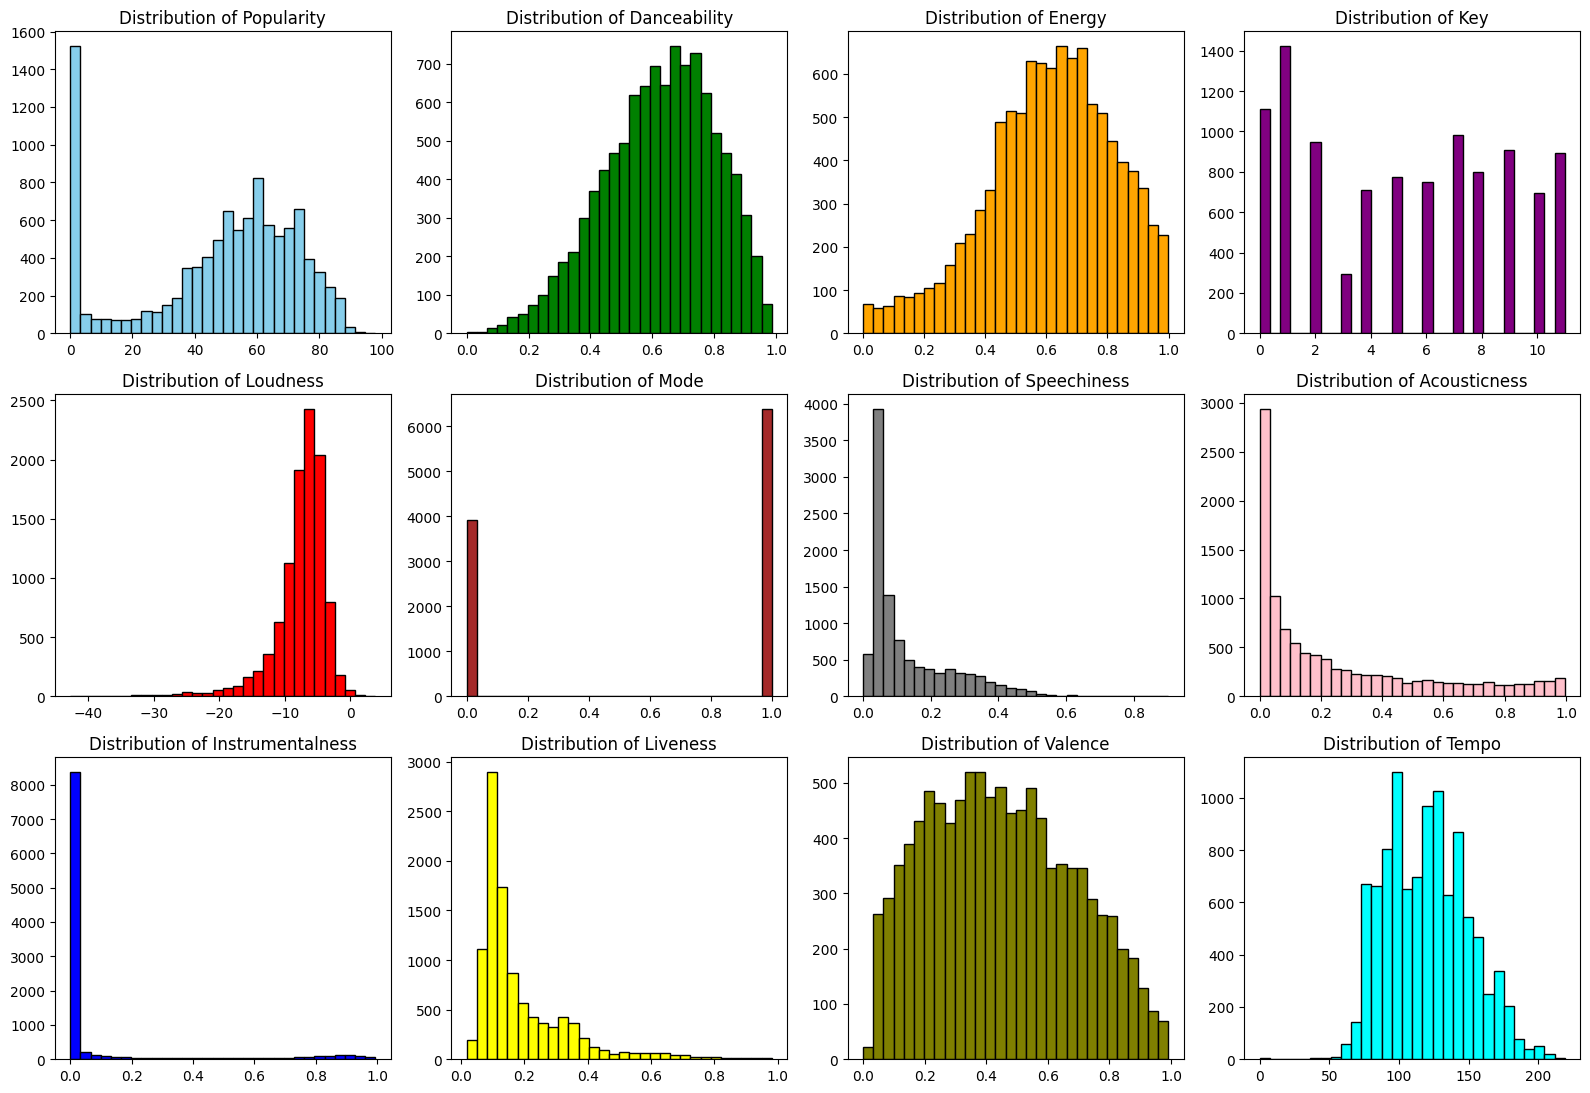

In [25]:
# visualize the distubution of features in the dataset
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

features = ['popularity','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']
colors = ['skyblue', 'green', 'orange', 'purple', 'red', 'brown', 'gray', 'pink', 'blue', 'yellow', 'olive','cyan']

for feature, color, ax in zip(features, colors, axes.flatten()):
    ax.hist(music_data[feature], bins=30, color=color, edgecolor='black')
    ax.set_title(f'Distribution of {feature.capitalize()}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Dataset Overview

The Spotify dataset used in this project encompasses a diverse set of features, each providing valuable insights into the characteristics of music tracks. Here's a brief overview of the key features:

- track_name (not used in feature analysis): The name of the track.
- artist_name (not used in feature analysis): The name of the artist.
- popularity: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by an algorithm and is based, for the most part, on the total number of plays the track has had and how recent those plays are.
- danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements, including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g., 0 = C, 1 = C/D, 2 = D, and so on. If no key was detected, the value is -1.
- loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing the relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 dB..
- mode: Mode indicates the modality (major or minor) of a track and the type of scale from which its melodic content is derived. Major is represented by 1, and minor is 0.
- speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g., talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence that the track is acoustic.
- instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal." The closer the instrumentalness value is to 1.0, the greater the likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g., sad, depressed, angry).
- tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

These features collectively offer a comprehensive view of the musical attributes of each track, providing a solid foundation for exploring patterns and relationships, and applying machine learning techniques to the analysis.

## ML Approaches
Through my research, I found that there are many various machine learning algorithms employed when dealing with musical datasets and features. Many of these deal with the problem of classifying music through feature analysis. Though most of the time it is hard to define music and audio through specific classes, there are unsupervised algorithms that eliminate the need for label data, which makes algorithms focus more on finding similarities in songs and audio.

- Unsupervised K nearest neighbors (KNN) can be applied to music data for tasks such as similarity search and recommendation. Given a query song, KNN identifies the K most similar songs from the dataset based on their feature similarity, where features can include audio characteristics, metadata, or user preferences.

- Deep learning approaches, such as convolutional neural networks (CNNs) and recurrent neural networks (RNNs), are applied to music data for tasks ranging from audio classification and genre recognition to music generation and recommendation. These models can learn hierarchical representations of music features directly from raw audio signals or from higher-level representations extracted from audio spectrograms or other feature representations.

- Unsupervised clustering algorithms are used to group similar pieces of music together based on their features without the need for labeled data. For example, clustering algorithms like K-means or hierarchical clustering can group songs into clusters based on their audio features, such as tempo, energy, and human-defined characteristics.

### Decision
Given that the goal of my project is to explore patterns and relationships among different musical features, I found that clustering algorithms are particularly well-suited for this task. Clustering allows me to identify inherent structures within the dataset, grouping together songs with similar characteristics. This is highly beneficial for discovering natural categories or genres that might exist within the music data. The numerical nature of the features, including danceability, energy, and tempo, aligns well with clustering techniques that can effectively analyze numeric patterns. Additionally, clustering offers the flexibility to adapt to the dataset's size, accommodating the substantial number of songs in my collection. By leveraging clustering algorithms, I aim to reveal meaningful insights into the inherent structure and patterns present in the diverse world of music, providing a foundation for personalized recommendations and a deeper understanding of the music dataset.

## Metrics

In creating my dataset, I decided that I would not include genre because I didn’t want a specific genre classification. This is also partly because I know from using Spotify that most of their genre classifications are a little off. Most genre classification labels in general are socially classified characteristics that don't always accurately describe modern-day music. Most machine learning projects that involve music clustering use genre as a ground truth to test the accuracy of their models, but without any labels for my dataset, the problem of measuring accuracy becomes a little tricky. Although there are a couple metrics for unsupervised clustering algorithms in Scikit-Learn's libraries that will give the metrics for how well the algorithms are clustering the songs.

- The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Cohesion and separation are the most fundamental metrics used to evaluate clustering algorithms. Cohesion measures how closely related the data points in a cluster are, while separation measures the degree of dissimilarity between clusters. A good clustering algorithm should produce clusters with high levels of cohesion and separation. The silhouette score ranges from -1 to 1; 1 indicates that the sample is well-clustered; -1 indicates that the sample may be assigned to the wrong cluster; 0 indicates overlapping clusters. 

- The Calinski-Harabasz index (also known as the variance ratio criterion) measures the ratio of between-cluster dispersion to within-cluster dispersion. It evaluates the separation between clusters and the compactness of clusters. The index is computed as the ratio of the sum of between-cluster dispersion and the sum of within-cluster dispersion. Higher values of the index indicate better-defined clusters.

- The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster, where similarity is defined based on the ratio of within-cluster scatter to between-cluster separation. The Davies-Bouldin index is the average ratio of the sum of within-cluster scatter and between-cluster separation for each cluster. Lower values of the index indicate better clustering, with 0 indicating perfectly separated clusters.

## Experiments and Results

In [38]:
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

### Hyperparameter Definition

In [40]:
# Initialize variables
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 8,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

# Update parameters with dataset-specific values
params = default_base.copy()

# Assuming music_data and selected_features are defined elsewhere
# Load music data from CSV file
music_data = pd.read_csv('spotify_liked.csv')
selected_features = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = StandardScaler().fit_transform(music_data[selected_features])

# Estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

# Connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params["n_neighbors"], include_self=False
)
# Make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# Create cluster objects
clustering_algorithms = [
    ("MiniBatch KMeans", cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"]
    )),
    ("Affinity Propagation", cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"]
    )),
    ("MeanShift", cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)),
    ("Spectral Clustering", cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"]
    )),
    ("Ward", cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"],
        linkage="ward",
        connectivity=connectivity
    )),
    ("Agglomerative Clustering", cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity
    )),
    # ("DBSCAN", cluster.DBSCAN(eps=params["eps"])),
    ("HDBSCAN", cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"]
    )),
    # ("OPTICS", cluster.OPTICS(
    #     min_samples=params["min_samples"],
    #     xi=params["xi"],
    #     min_cluster_size=params["min_cluster_size"]
    # )),
    ("BIRCH", cluster.Birch(n_clusters=params["n_clusters"])),
    ("Gaussian\nMixture", mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"]
    )),
]

### Cluster Training, Visualization, Metrics

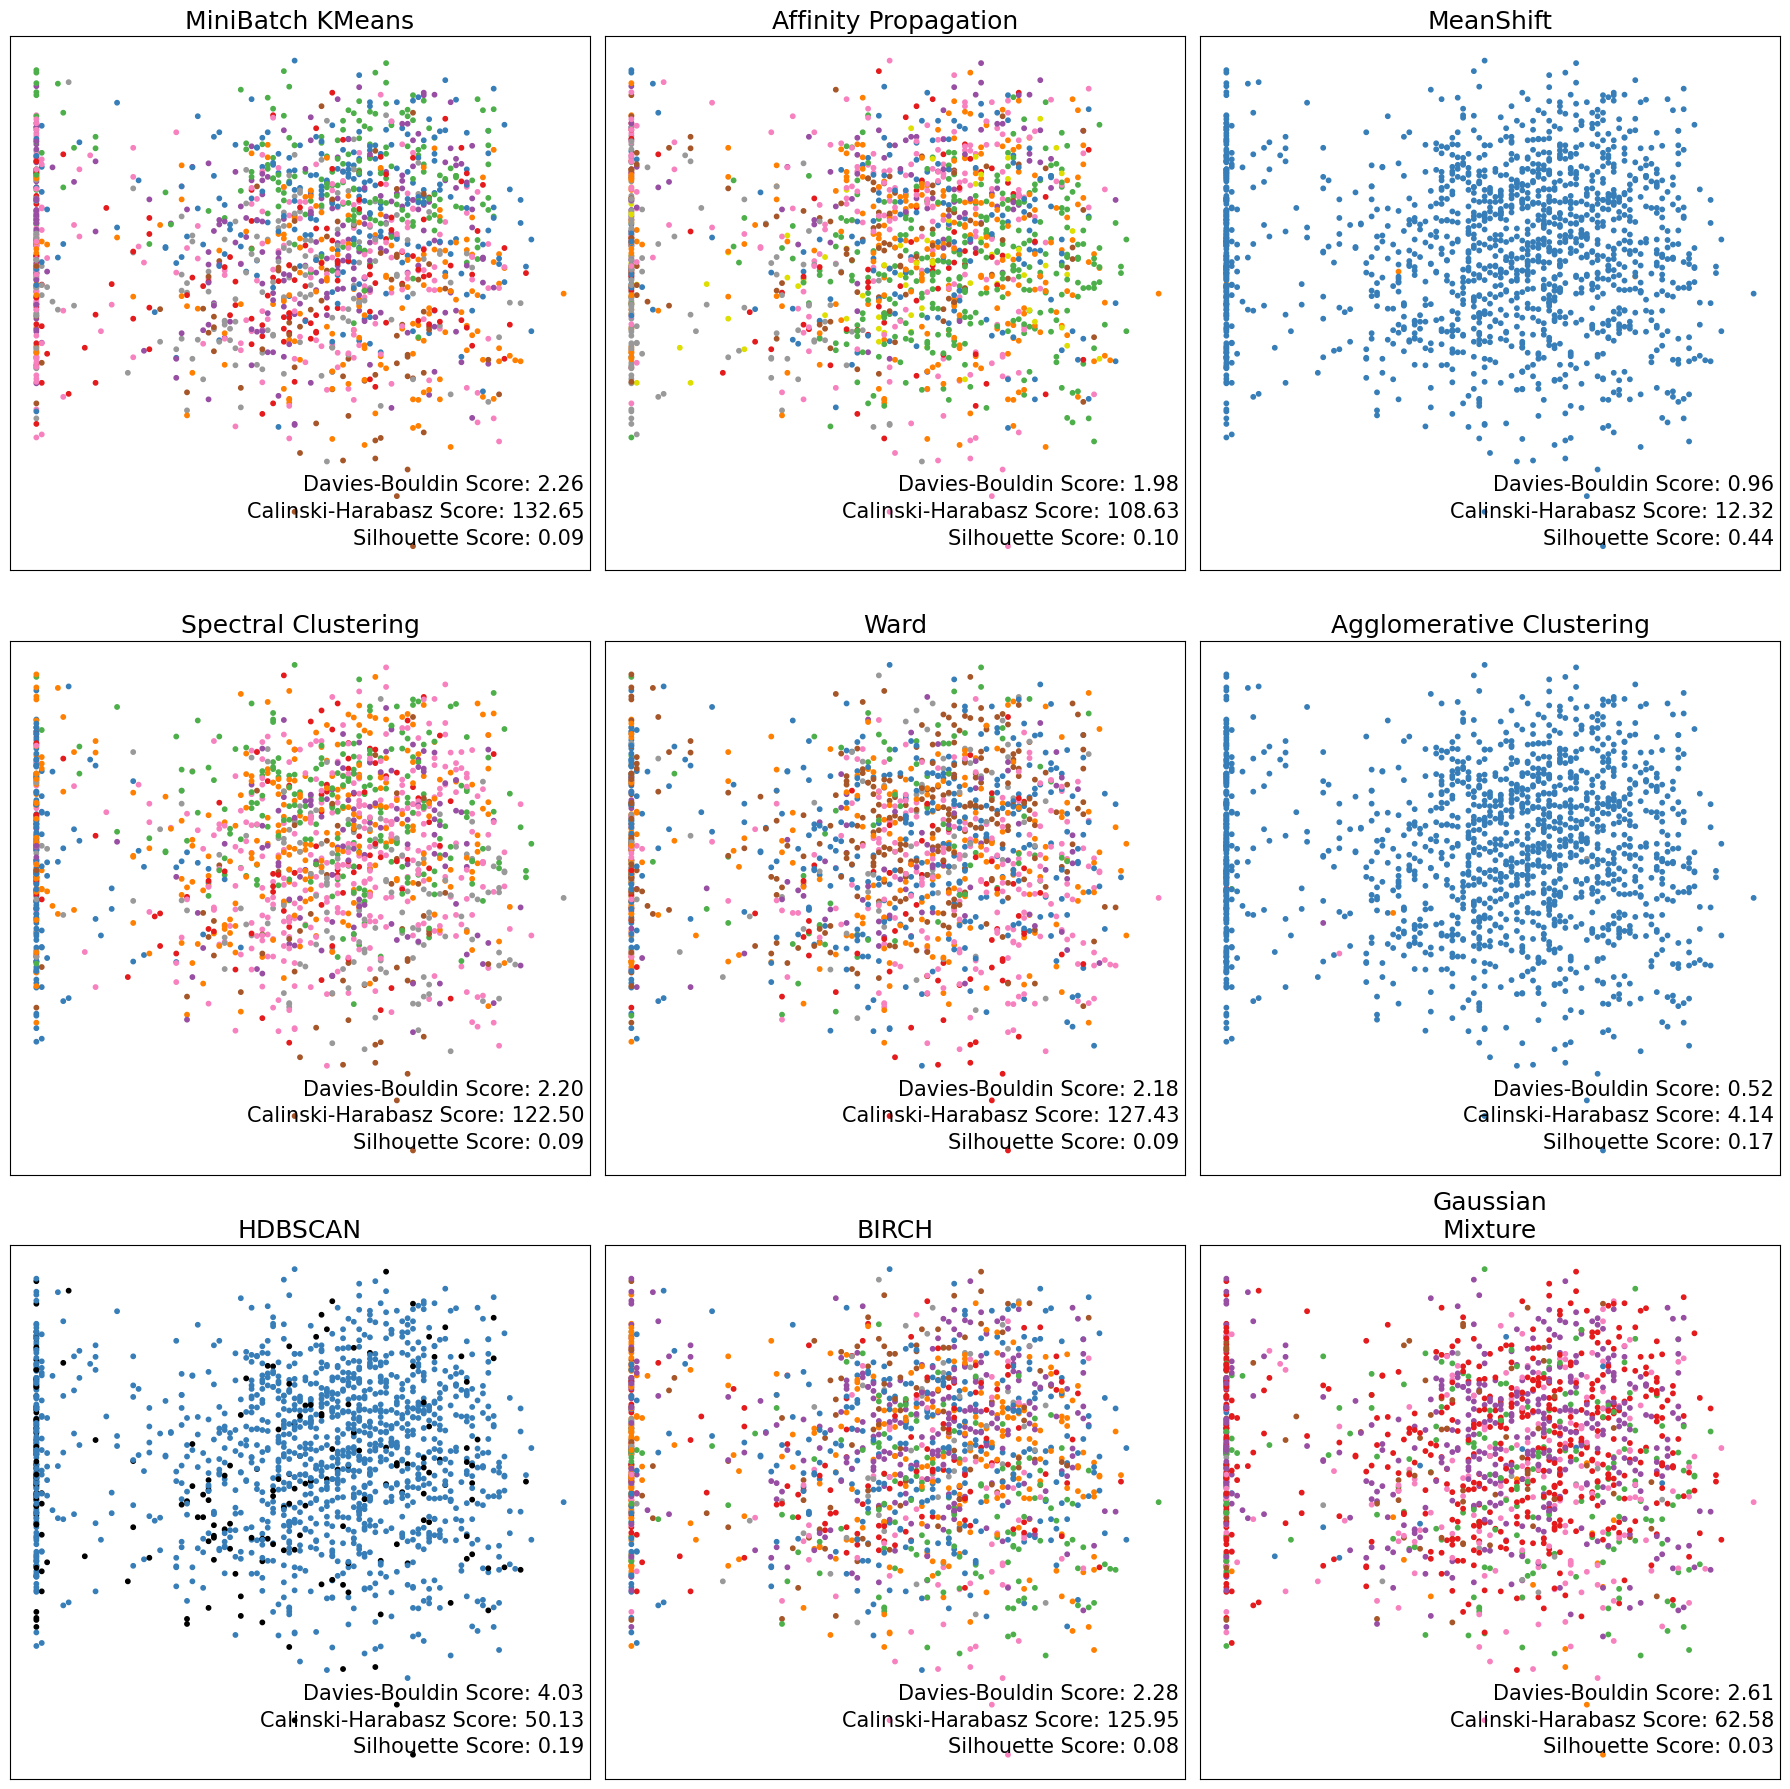

In [55]:
plot_num = 1
num_plots = len(clustering_algorithms)
num_rows = (num_plots - 1) // 3 + 1

fig, axs = plt.subplots(num_rows, 3, figsize=(18, num_rows * 6))

for idx, (name, algorithm) in enumerate(clustering_algorithms):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="the number of connected components of the connectivity matrix is [0-9]{1,2} > 1. Completing it to avoid stopping the tree early.", category=UserWarning)
        warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding may not work as expected.", category=UserWarning)
        algorithm.fit(X)

    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    ax = axs[idx // 3, idx % 3]
    ax.set_title(name, size=18)
    # print("Model",name)
    # print(f"Silhouette Score: {silhouette:.3f}")
    # print(f"Calinski-Harabasz Score: {calinski_harabasz:.3f}")
    # print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

    colors = np.array(list(islice(cycle(["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]), int(max(y_pred) + 1))))
    colors = np.append(colors, ["#000000"])
    ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    ax.set_xticks(())
    ax.set_yticks(())

    silhouette = silhouette_score(X, y_pred)
    calinski_harabasz = calinski_harabasz_score(X, y_pred)
    davies_bouldin = davies_bouldin_score(X, y_pred)
    ax.text(0.99, 0.05, f"Silhouette Score: {silhouette:.2f}", transform=ax.transAxes, size=15, horizontalalignment="right")
    ax.text(0.99, 0.1, f"Calinski-Harabasz Score: {calinski_harabasz:.2f}", transform=ax.transAxes, size=15, horizontalalignment="right")
    ax.text(0.99, 0.15, f"Davies-Bouldin Score: {davies_bouldin:.2f}", transform=ax.transAxes, size=15, horizontalalignment="right")

plt.tight_layout()
plt.show()

### Model Application

In [45]:
# load music data from csv, pre-process to selected features, normalize data
music_data = pd.read_csv('spotify_liked.csv')
selected_features = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = StandardScaler().fit_transform(music_data[selected_features])

# Randomly select a user input song
# user_input_index = np.random.choice(music_data.index)
user_input_index = 288
user_input_index = (user_input_index)-2
user_song = music_data.loc[user_input_index, selected_features].to_dict()


# Iterate over each clustering algorithm
for name, algorithm in clustering_algorithms:
    # Perform clustering
    music_data['cluster'] = algorithm.fit_predict(music_data[selected_features])

    # Get cluster label for the user input song
    user_song_cluster = music_data.loc[user_input_index, 'cluster']

    # Filter music data to include only songs from the cluster of the user input song
    cluster_songs = music_data[music_data['cluster'] == user_song_cluster]

    # Calculate Euclidean distances between the user input song and all songs in the cluster
    distances = euclidean_distances([list(user_song.values())], cluster_songs[selected_features])[0]

    # Sort songs based on distances (closest first)
    sorted_indices = np.argsort(distances)

    # Print the user input song
    print(f"\nModel: {name}, Cluster: {user_song_cluster}")
    print(f"User Input Song: {music_data.loc[user_input_index, 'track_name']} by {music_data.loc[user_input_index, 'artist_name']}")

    # Print recommended songs (closest in cluster)
    print("Recommended Songs:")
    for index in sorted_indices[:7]:  # Print top 10 closest songs
        print(f"{cluster_songs.iloc[index]['track_name']} by {cluster_songs.iloc[index]['artist_name']}")


Model: MiniBatch KMeans, Cluster: 1
User Input Song: Dark Red by Steve Lacy
Recommended Songs:
Dark Red by Steve Lacy
Best Day Ever by Mac Miller
Hero by Family of the Year
The Apartment by Foreign Air
Playlist by Kid Quill
Like A Star by Mike Krol
Wet Dreamz by J. Cole

Model: Affinity Propagation, Cluster: 83
User Input Song: Dark Red by Steve Lacy
Recommended Songs:
Dark Red by Steve Lacy
Best Day Ever by Mac Miller
The Apartment by Foreign Air
Playlist by Kid Quill
Like A Star by Mike Krol
3005 by Childish Gambino
Advice by Alex G

Model: MeanShift, Cluster: 626
User Input Song: Dark Red by Steve Lacy
Recommended Songs:
Dark Red by Steve Lacy

Model: Spectral Clustering, Cluster: 5
User Input Song: Dark Red by Steve Lacy
Recommended Songs:
Dark Red by Steve Lacy
Best Day Ever by Mac Miller
Hero by Family of the Year
The Apartment by Foreign Air
Playlist by Kid Quill
Like A Star by Mike Krol
Wet Dreamz by J. Cole

Model: Ward, Cluster: 4
User Input Song: Dark Red by Steve Lacy
Reco

### Discussion

Spectral Clustering and HDBSCAN seem to perform well overall, with relatively high Silhouette Scores and low Davies-Bouldin Scores, indicating well-separated clusters.

- Spectral Clustering, leveraging spectral graph theory, effectively captures complex relationships between data points, leading to well-separated clusters.
- HDBSCAN, recognized for its density-based approach, showcases robustness in identifying clusters of varying shapes and densities, making it a preferred choice for challenging datasets.

MiniBatch KMeans and BIRCH perform relatively poorly, with lower Silhouette Scores and higher Davies-Bouldin Scores, suggesting less distinct or overlapping clusters.

- MiniBatch KMeans, though computationally efficient, tends to struggle with determining the optimal number of clusters and may produce suboptimal results in complex data distributions.
- BIRCH, while offering scalability through its tree-based structure, may encounter difficulties in accurately representing clusters with varying densities or shapes, affecting its overall performance.

Affinity Propagation, MeanShift, Ward, Agglomerative Clustering, and Gaussian Mixture fall somewhere in between, with varying degrees of performance across different metrics.

- Affinity Propagation's sensitivity to parameters and MeanShift's reliance on data density pose challenges in achieving consistent clustering results across diverse datasets.
- Ward and Agglomerative Clustering exhibit hierarchical clustering behavior, offering insights into cluster structures but may struggle with scalability and computational complexity.
- Gaussian Mixture Models, assuming Gaussian distributions for clusters, provide a probabilistic framework for clustering but may not fully capture the underlying data distribution in complex datasets.


## Conclusions

This project explored various clustering algorithms applied to music data to uncover underlying patterns and group similar songs together. Musical data can come in many forms, and I decided to narrow in on high-level audio features. While this made it easy to generate fully personalized datasets with over 10,000 samples, it was also limited to what Spotify’s Web API had to offer in terms of their own algorithmically defined audio features. In the future, it might be worthwhile to attempt this project on a larger dataset or even focus more on low-level features to fully capture the nuances of auditory data. It is also important to note that through further research, I found that Spotify’s own music recommendation generation algorithm focuses less on high and low audio features but instead on user-based features like millions of user playlists and listening histories, which is just outside the scope of this project and not realistically achievable on a small scale.

After assessing the accuracy metrics of the unsupervised clustering algorithms, it was clear that some algorithms did perform better than others based on a number of variables, like how the model was structured, how the model calculated relationships, and hyperparameter tuning. While these metrics were a concrete way of analyzing the performance of these algorithms, generating the recommendations based on my own music selection gave me the ability to actually choose the input song and assess the recommendations based on my own personal knowledge and experience. Looking at the results generated by the clustering algorithms, it is very clear that some of the recommendations make no sense, with most of the algorithms recommending songs from completely different genres and songs with completely different vibes from what I know. However, there were some surprising and decent suggestions that were given by the gaussian mixture and ward algorithms.

In conclusion, through comprehensive experimentation and evaluation, I gained valuable insights into the strengths and limitations of each algorithm in handling the complexity and diversity of high-level musical features.


### References

https://www.interviewquery.com/p/music-machine-learning

https://dc.uwm.edu/cgi/viewcontent.cgi?article=3844&context=etd



https://www.kaggle.com/c/msdchallenge/data

https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated

https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset



https://scikit-learn.org/stable/modules/neighbors.html

https://scikit-learn.org/stable/modules/clustering.html

https://www.codemotion.com/magazine/ai-ml/machine-learning/clustering-python-patterns/	



https://medium.com/latinxinai/discovering-descriptive-music-genres-using-k-means-clustering-d19bdea5e443

https://www.kaggle.com/code/sivarazadi/k-means-spotify-song-clustering

https://www.analyticsvidhya.com/blog/2022/03/music-genre-classification-project-using-machine-learning-techniques/

https://musicinformationretrieval.com/kmeans.html

Your report for a single person team should contain approximately 2,000 words times number of team members, in markdown cells.  You can count words by running the following python code in your report directory.  Projects with two people, for example, should contain about 4,000 words, a four-person team should submit a report of approximately 8,000 words.

Of course, your results and analysis speak much more than the word count.  Deep analysis in a shorter form is better than vague, over-wordy non-analysis.

In [58]:
# calculate word count
import io
import nbformat
import glob

nbfile = glob.glob('Truong-Project-Report.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one. nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print('Word count for file', nbfile[0], 'is', word_count)


Word count for file Truong-Project-Report.ipynb is 2452
